In [178]:
import tensorflow_datasets.public_api as tfds

import numpy as np # linear cebir
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [179]:
ham_veri = tfds.load(name="mnist", split=tfds.Split.TRAIN)
ham_veri

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [180]:
len(ham_veri)

60000

In [181]:
resim_boyutu = 7

In [182]:
def resmi_boyutlandir(ornek):
    resim = ornek['image']
    resim = tf.image.resize(resim, (resim_boyutu, resim_boyutu))
    return {'image': resim, 'label': ornek['label']}

In [183]:
veriseti = ham_veri.map(resmi_boyutlandir)

In [205]:
# ReLU fonksiyonu gelen değer 0'dan küçükse 0'a eşitler, diğer durumlarda değeri olduğu gibi bırakır.
def ReLU(degerler):
    degerler[degerler < 0] = 0
    return degerler

In [185]:
def tahmin_et(ornek, agirliklar, biaslar):
    birinci_katman = np.matmul(ornek, agirliklar[0])
    birinci_katman = birinci_katman + biaslar[0]
    birinci_katman = ReLU(birinci_katman)
    
    ikinci_katman = np.matmul(birinci_katman, agirliklar[1])
    
    # Üçüncü katmanın çıktısını hesaplamak için softmax fonksiyonunu kullanıyoruz.
    # Softmax fonksiyonu, çıktıları olasılık değerlerine dönüştürür. Şu şekilde çalışır:
    # 1. İkinci katmandan gelen değerlerin exp() fonksiyonunu alır.
    # 2. Bu değerleri toplar.
    # 3. Her bir değeri toplam değere böler.
    # Bu işlem sonucunda, her bir çıktı değeri 0 ile 1 arasında bir değer alır ve toplam değer 1 olur.
    softmax_pay = np.exp(ikinci_katman)
    softmax_payda = np.sum(softmax_pay, axis=1).reshape(-1,1)
    softmax = softmax_pay / softmax_payda
    return softmax

In [186]:
def kayip_hesapla(y_tahmin, y_gercek):
    '''
    Kayıp fonksiyonu, modelin tahminlerinin ne kadar yanlış olduğunu ölçer.
    Bu örnekte, çok sınıflı çapraz entropi kaybını kullanıyoruz.
    Şu şekilde çalışır:
    1. Her bir örneğin gerçek etiketinin one-hot encoding'ini alır.
    2. Modelin tahminlerini logaritma alır.
    3. Her bir örneğin kaybını hesaplar.
    4. Tüm örneklerin kaybının ortalamasını alır.    
    '''
    global sinif_sayisi
    sinif_sayisi = 10
    ornek_sayisi = len(y_gercek)

    # One-hot encoding
    y_gercek_one_hot = (y_gercek[:, np.newaxis] == np.arange(sinif_sayisi))
    # Şu şekilde bir matris oluşturur:
    # [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    #  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    #  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    #  ...
    #  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]

    # Her bir örneğin kaybını hesaplar
    kayip_ornek = (np.log(y_tahmin) * y_gercek_one_hot).sum(axis=1)
    # Tüm örneklerin kaybının ortalamasını alır
    return -np.mean(kayip_ornek)

In [187]:
def backprop(W, b, X, y, alpha = 1e-4):
    '''
    Step 1: explicit forward pass h(X;W,b)
    Step 2: backpropagation for dW and db
    '''
    K = 10
    N = X.shape[0]
    
    ### Step 1:
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    # layer 2 activation
    a2 = ReLU(z1)
    
    # one more layer
    
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    
    ### Step 2:
    
    # layer 2->layer 3 weights' derivative
    # delta2 is \partial L/partial z2, of shape (N,K)
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)
    
    # layer 1->layer 2 weights' derivative
    # delta1 is \partial a2/partial z1
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)
    
    # Possible student project: extra layer of derivative
    
    # no derivative for layer 1
    
    # the alpha part is the derivative for the regularization
    # regularization = 0.5*alpha*(np.sum(W[1]**2) + np.sum(W[0]**2))
    
    
    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]
    db = [np.mean(delta1, axis=0)]
    # dW[0] is W[0]'s derivative, and dW[1] is W[1]'s derivative; similar for db
    return dW, db

In [188]:
y_veri = np.array([ornek["label"] for ornek in tfds.as_numpy(veriseti)])
X_veri = np.array([ornek["image"].reshape(-1) for ornek in tfds.as_numpy(veriseti)]) / 255

2024-06-23 04:20:24.995147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-23 04:20:28.137144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [189]:
X_test = X_veri[:1000]
y_test = y_veri[:1000]

X_egitim = X_veri[1000:]
y_egitim = y_veri[1000:]

print(X_egitim.shape, y_egitim.shape)
print(X_test.shape, y_test.shape)

(59000, 49) (59000,)
(1000, 49) (1000,)


In [190]:
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
num_iter = 100 # number of iterations of gradient descent
n_H = 16 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
sinif_sayisi = 10

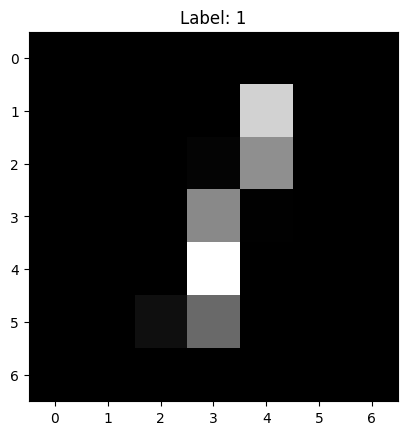

In [196]:
resim_sirasi = 1
def show_image(X):
    '''
    Show the image in X, which is a 1D array
    '''
    plt.imshow(X.reshape(resim_boyutu, resim_boyutu), cmap='gray')
    # set title to be the label of the image
    plt.title(f"Label: {y_test[resim_sirasi]}")
    plt.show()

show_image(X_test[resim_sirasi])


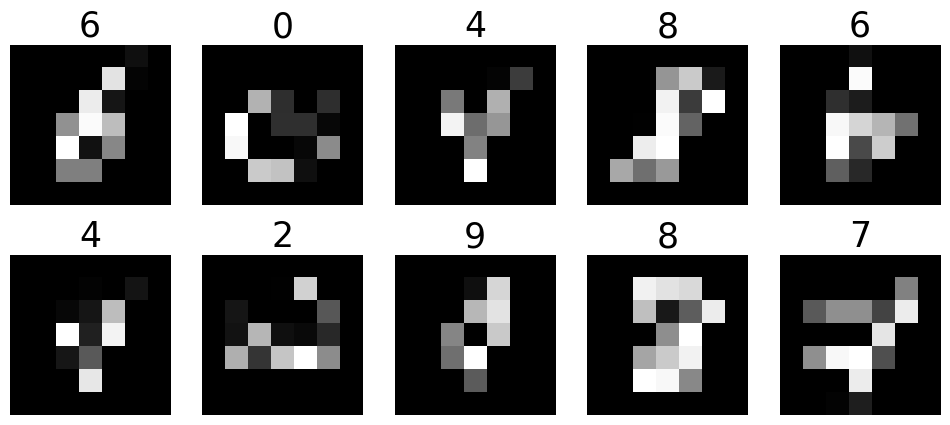

In [197]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(X_egitim[idx[i],:].reshape(resim_boyutu, resim_boyutu), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_egitim[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [198]:
# initialization
np.random.seed(42)
# W = [1e-1 * np.random.randn(n, n_H), 1e-1 * np.random.randn(n_H, K)]
# init weight and bias in data type float16
W = [1e-1 * np.random.randn(n, n_H).astype(np.float16), 1e-1 * np.random.randn(n_H, sinif_sayisi).astype(np.float16)]
b = [np.random.randn(n_H).astype(np.float16)]

In [199]:
W_0_df = pd.DataFrame(W[0])
W_0_df.index += 1
W_0_df.columns += 1
W_0_df.to_csv("W_0.csv", sep='\t')

In [200]:
W_1_df = pd.DataFrame(W[1])
W_1_df.index += 1
W_1_df.columns += 1
W_1_df.to_csv("W_1.csv", sep='\t')

In [201]:
b_df = pd.DataFrame(b)
b_df.index += 1
b_df.columns += 1
b_df.to_csv("b.csv", sep='\t')

In [202]:
W[0].shape, W[1].shape, b[0].shape

((49, 16), (16, 10), (16,))

In [217]:
%%time
gW0 = gW1 = gb0 = 1

for i in range(num_iter):
    dW, db = backprop(W, b, X_train, y_egitim, alpha)
    
    gW0 = gamma*gW0 + (1 - gamma) * np.sum(dW[0]**2)
    etaW0 = eta / np.sqrt(gW0 + eps)
    W[0] -= etaW0 * dW[0]
    
    gW1 = gamma*gW1 + (1 - gamma) * np.sum(dW[1]**2)
    etaW1 = eta / np.sqrt(gW1 + eps)
    W[1] -= etaW1 * dW[1]
    
    gb0 = gamma*gb0 + (1 - gamma) * np.sum(db[0]**2)
    etab0 = eta / np.sqrt(gb0 + eps)
    b[0] -= etab0 * db[0]
    
    if i % 500 == 0:
        # sanity check 1
        y_pred = tahmin_et(X_egitim, W, b)
        print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(
              kayip_hesapla(y_pred, y_egitim)))
        print("Training accuracy after", i+1, "iterations is {:.4%}".format( 
              np.mean(np.argmax(y_pred, axis=1) == y_egitim)))
        
        # sanity check 2
        print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
              .format(gW0, gW1, gb0, etaW0, etaW1, etab0))
        
        # sanity check 3
        print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}"
             .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")
        
        # reset RMSprop
        gW0 = gW1 = gb0 = 1

y_pred_final = tahmin_et(X_train, W, b)
print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final, y_egitim)))
print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1) == y_egitim)))

Cross-entropy loss after 1 iterations is 0.61836272
Training accuracy after 1 iterations is 80.3271%
gW0=0.9911 gW1=0.9919 gb0=0.9904
etaW0=0.5020 etaW1=0.5018 etab0=0.5022
|dW0|=0.32671 |dW1|=0.43038 |db0|=0.21095 

Final cross-entropy loss is 0.62550193
Final training accuracy is 79.5881%
CPU times: user 22.7 s, sys: 856 ms, total: 23.6 s
Wall time: 2.16 s


In [218]:
# predictions
y_pred_test = np.argmax(tahmin_et(X_test, W, b), axis=1)
print("Test accuracy is {:.4%}".format(np.mean(y_pred_test == y_test)))

Test accuracy is 78.8000%


In [219]:
tahmin_et([X_test[0]], W, b), y_test[0]#, np.argmax(h([X_test[0]], W, b))

(array([[0.00078116, 0.00058687, 0.00342958, 0.00176119, 0.4605188 ,
         0.06675062, 0.01968243, 0.00416831, 0.18889968, 0.25342143]],
       dtype=float32),
 4)

In [220]:
pd.DataFrame(X_test[2])

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [221]:
y_pred_test[:10], y_test[:10]

(array([4, 1, 0, 7, 3, 1, 2, 7, 1, 6]), array([4, 1, 0, 7, 8, 1, 2, 7, 1, 6]))